# Required Path Setup 
  * test_file_path: Path to the testing images folder, i.e., Path to the Public test data or Path to the Custom test data.
  * output_csv: Path to output the predicted localization and classification details.
  * output_zip: Path to output the segmented signboards on input images.

In [1]:
test_file_path = 'Test Data'
output_csv = 'output.csv'
output_zip = 'result.zip'

Define Tensorflow Version

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Install Keras 2.2.4 and Required Libraries

In [3]:
!pip install Keras==2.2.4

### Run Signboard Detection Model.
 * A zip file containing annotated images and a CSV file with signbaord localization details will be ready for download.

Using TensorFlow backend.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loading weights from signboard_model_frcnn_vgg.hdf5

Input file:  22.png


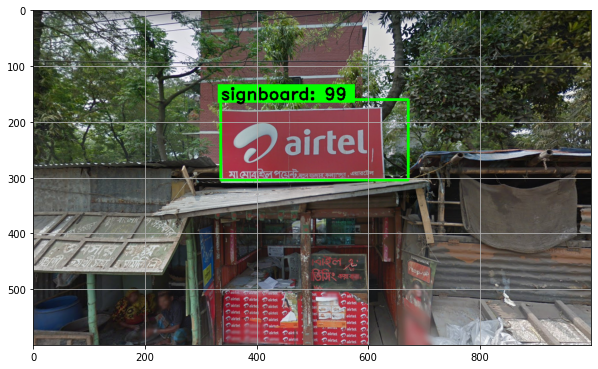

Input file:  97.png


KeyboardInterrupt: ignored

In [4]:
!pip install Keras==2.2.4
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
tf.version.VERSION
import pandas as pd
import os
from sklearn.metrics import average_precision_score
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed, Activation
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers
from google.colab import files	
from google.colab import drive	
from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd	
from PIL import Image
from zipfile import ZipFile	
import time	
import re
import argparse
from google.colab import files

class Config:

  def __init__(self):
    self.verbose = True

def main(test_file_path, output_csv, output_zip):
    model_file_path = 'signboard_model_frcnn_vgg.hdf5'
    config_file_path = 'signboard_model_vgg_config.pickle'
    if not os.path.isfile('signboard_detector.py'):
      gdd.download_file_from_google_drive(file_id='1rTNk4H_LHa3n24_H7fJOLjr3dGbiDdL3', dest_path='./Signboard_Detector.zip', unzip=True)
    from Signboard_Detector import signboard_detector as fn
    with open(config_file_path, 'rb') as f_in:
      C = pickle.load(f_in)
      
    st = time.time()
    Max_boxes = 300
    rpn_ov_thresh = 0.9  # 0.7 or 0.3
    nms_ov_thresh = 0.2 # 0.5 or 0.3
    bbox_threshold = 0.7 #0.7 # 0.5
    num_features = 512
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)
    img_input = Input(shape=input_shape_img)
    roi_input = Input(shape=(C.num_rois, 4))
    feature_map_input = Input(shape=input_shape_features)
    # define the base network (VGG here, can be Resnet50, Inception, etc)
    shared_layers = fn.VGG16_BN(img_input,conv_dropout=0.1, activation='relu')
    # define the RPN, built on the base layers
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
    rpn_layers = fn.rpn_layer(shared_layers, num_anchors)
    classifier = fn.classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))
    model_rpn = Model(img_input, rpn_layers)
    model_classifier_only = Model([feature_map_input, roi_input], classifier)
    model_classifier = Model([feature_map_input, roi_input], classifier)
    # Switch key value for class mapping
    class_mapping = C.class_mapping
    #class_mapping = cm
    class_mapping = {v: k for k, v in class_mapping.items()}
    #print(class_mapping)
    class_to_color = {class_mapping[v]: (0, 255, 3) for v in class_mapping}
    print('Loading weights from {}'.format(model_file_path))
    model_rpn.load_weights(model_file_path, by_name=True)
    model_classifier.load_weights(model_file_path, by_name=True)
    model_rpn.compile(optimizer='sgd', loss='mse')
    model_classifier.compile(optimizer='sgd', loss='mse')

    # If the box classification value is less than this, we ignore this box
    record_df = pd.DataFrame(columns=['File_Name', 'X1','Y1','X2','Y2','Width','Height','Label_Name','Confidence_Score'])
    zipObj = ZipFile(output_zip, 'w')
    record_path = output_csv
    if not os.path.isdir(test_file_path):
      print('Warning ! "Input" folder is not found..\nPlease upload your input zip file with mentioned format and run the tool again.')
    if not os.path.isfile(model_file_path) or not os.path.isfile(config_file_path) :
      print('Warning ! Detection model file is not found..\nPlease download Signbord_Classifier.zip and run the tool agian.')
    
    test_imgs = os.listdir(test_file_path)
    imgs_path = []
    for i in range(len(test_imgs)):
        imgs_path.append(test_imgs[i])
    all_imgs = []
    classes = {}
    
    for idx, img_name in enumerate(imgs_path):
        if img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
            print('Input file: ' ,img_name)
        else: 
            print('Warning ! Input image format is incorrect, upload the input with mentioned format and run the tool agian.')
        filepath = os.path.join(test_file_path, img_name)
        img = cv2.imread(filepath)
        wid, hei, _ = img.shape
        if wid !=1000 and hei !=600:
          #img = img.resize((1000, 600), Image.ANTIALIAS)
          img = cv2.resize(img, (1000, 600), interpolation=cv2.INTER_CUBIC)
        X, ratio = fn.format_img(img, C)
        X = np.transpose(X, (0, 2, 3, 1))
        # get output layer Y1, Y2 from the RPN and the feature maps F
        # Y1: y_rpn_cls
        # Y2: y_rpn_regr
        [Y1, Y2, F] = model_rpn.predict(X)
        # Get bboxes by applying NMS 
        # R.shape = (300, 4)
        R = fn.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(),overlap_thresh=0.9)
        # convert from (x1,y1,x2,y2) to (x,y,w,h)
        R[:, 2] -= R[:, 0]
        R[:, 3] -= R[:, 1]
        # apply the spatial pyramid pooling to the proposed regions
        bboxes = {}
        probs = {}
        for jk in range(R.shape[0]//C.num_rois + 1):
            ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
            if ROIs.shape[1] == 0:
                break
            if jk == R.shape[0]//C.num_rois:
                #pad R
                curr_shape = ROIs.shape
                target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
                ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                ROIs_padded[:, :curr_shape[1], :] = ROIs
                ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                ROIs = ROIs_padded
            [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
            # Calculate bboxes coordinates on resized image
            for ii in range(P_cls.shape[1]):
                # Ignore 'bg' class
                if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                    continue
                cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
                if cls_name not in bboxes:
                    bboxes[cls_name] = []
                    probs[cls_name] = []
                (x, y, w, h) = ROIs[0, ii, :]
                cls_num = np.argmax(P_cls[0, ii, :])
                try:
                    (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                    tx /= C.classifier_regr_std[0]
                    ty /= C.classifier_regr_std[1]
                    tw /= C.classifier_regr_std[2]
                    th /= C.classifier_regr_std[3]
                    x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
                except:
                    pass
                bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
                probs[cls_name].append(np.max(P_cls[0, ii, :]))
        all_dets = []
        for key in bboxes:
            bbox = np.array(bboxes[key])
            new_boxes, new_probs = fn.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=nms_ov_thresh,max_boxes=Max_boxes)
            for jk in range(new_boxes.shape[0]):
                (x1, y1, x2, y2) = new_boxes[jk,:]
                # Calculate real coordinates on original image
                (real_x1, real_y1, real_x2, real_y2) = fn.get_real_coordinates(ratio, x1, y1, x2, y2)
                cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)
                textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
                all_dets.append((key,100*new_probs[jk]))
                (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
                textOrg = (real_x1, real_y1-0)
                cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
                cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 255, 3), -1)
                cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 2)
                new_row = {'File_Name':img_name, 
                      'X1':real_x1, 
                      'Y1':real_y1, 
                      'X2':real_x2, 
                      'Y2':real_y2, 
                      'Width':abs(real_x2-real_x1), 
                      'Height':abs(real_y2-real_y1),
                      'Label_Name':key,
                      'Confidence_Score':round(100*new_probs[jk],2)
                      }
                record_df = record_df.append(new_row, ignore_index=True)
        #print('Elapsed time = {}'.format(time.time() - st))
        #print(all_dets)
        plt.figure(figsize=(10,10))
        plt.grid()
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.show()
        new_filename = 'Output_' + img_name
        plt.imsave(new_filename,cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        zipObj.write(new_filename)
        os.rename(new_filename,'temp.png')
    print('Total Execution time = {}[Sec]'.format(round(time.time() - st),2))
    record_df.to_csv(record_path, index=0)
    zipObj.write(record_path)
    zipObj.close()
    print('Detection complete ! output results have been created and archived into "Result.zip" file\nPlease approve the download.')
    if os.path.isfile(output_zip):
      files.download(output_zip)
    else:
      print("Output files not found! Please contact with authors.")


if __name__ == "__main__":
  main(test_file_path, output_csv, output_zip)